Starting Simulation (5000 steps)...
Step 0/5000
Step 100/5000
Step 200/5000
Step 300/5000
Step 400/5000
Step 500/5000
Step 600/5000
Step 700/5000
Step 800/5000
Step 900/5000
Step 1000/5000
Step 1100/5000
Step 1200/5000
Step 1300/5000
Step 1400/5000
Step 1500/5000
Step 1600/5000
Step 1700/5000
Step 1800/5000
Step 1900/5000
Step 2000/5000
Step 2100/5000
Step 2200/5000
Step 2300/5000
Step 2400/5000
Step 2500/5000
Step 2600/5000
Step 2700/5000
Step 2800/5000
Step 2900/5000
Step 3000/5000
Step 3100/5000
Step 3200/5000
Step 3300/5000
Step 3400/5000
Step 3500/5000
Step 3600/5000
Step 3700/5000
Step 3800/5000
Step 3900/5000
Step 4000/5000
Step 4100/5000
Step 4200/5000
Step 4300/5000
Step 4400/5000
Step 4500/5000
Step 4600/5000
Step 4700/5000
Step 4800/5000
Step 4900/5000


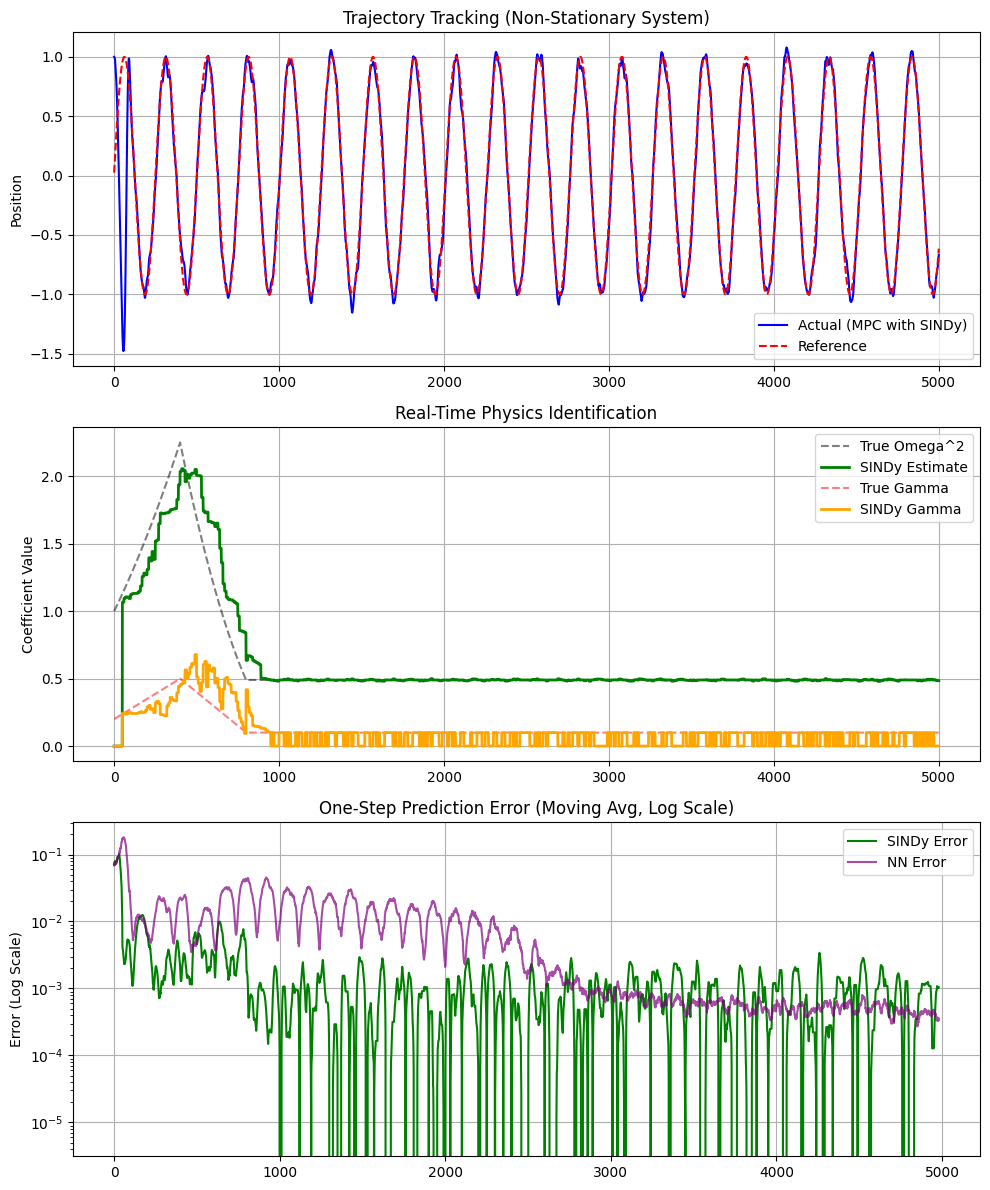

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================
# 0. Reference & Helpers
# ============================================================

def p_ref(t, dt):
    """Target trajectory: A sine wave we want to track."""
    time = t * dt
    return 1.0 * np.sin(0.5 * time)

def library(x, u):
    """
    Polynomial feature library.
    Features: [1, p, v, u, p^2, v^2, p*v, p*u, v*u, u^2]
    Indices:   0  1  2  3   4    5    6    7    8    9
    """
    p, v = x
    # Handle both 1D (single sample) and 2D (batch) inputs
    if np.ndim(p) == 0:
        return np.array([1, p, v, u, p**2, v**2, p*v, p*u, v*u, u**2])
    else:
        return np.stack([
            np.ones_like(p), p, v, u, p**2, v**2, p*v, p*u, v*u, u**2
        ], axis=1)

# ============================================================
# 1. Oscillator Environment (Non-stationary)
# ============================================================

class OscillatorEnv:
    def __init__(self, dt=0.05):
        self.dt = dt
        self.reset()

    def get_true_params(self, t_step):
        """Returns the True Omega and Gamma for a given timestep."""
        # Smooth drift logic
        if t_step < 400:
            # Phase 1: Drift up
            alpha = t_step / 400.0
            omega = 1.0 + 0.5 * alpha      # 1.0 -> 1.5
            gamma = 0.2 + 0.3 * alpha      # 0.2 -> 0.5
        elif t_step < 800:
            # Phase 2: Drift down
            alpha = (t_step - 400) / 400.0
            omega = 1.5 - 0.8 * alpha      # 1.5 -> 0.7
            gamma = 0.5 - 0.4 * alpha      # 0.5 -> 0.1
        else:
            # Phase 3: Steady
            omega = 0.7
            gamma = 0.1
        return omega, gamma

    def reset(self):
        self.t = 0
        self.x = np.array([1.0, 0.0])  # [position, velocity]
        return self.x.copy()

    def step(self, u):
        u = np.clip(u, -5, 5)
        p, v = self.x
        
        # Get physics parameters for current time
        omega, gamma = self.get_true_params(self.t)

        # Physics: dp = v, dv = -omega^2*p - gamma*v + u
        dp = v
        dv = -(omega**2) * p - gamma * v + u

        # Euler Integration
        self.x = self.x + self.dt * np.array([dp, dv])
        self.t += 1

        # Cost calculation
        pref = p_ref(self.t, self.dt)
        cost = (p - pref)**2 + 0.01 * u**2
        
        return self.x.copy(), -cost, omega, gamma

# ============================================================
# 2. SINDyC (With Sliding Window & Sparsity)
# ============================================================

class SINDyC:
    def __init__(self, window_size=300):
        self.window_size = window_size
        self.X = []
        self.Y = []
        # 10 features, 2 state variables (dp, dv)
        self.coeff = np.zeros((10, 2)) 
        
    def update(self, x, u, x_next, dt):
        # Compute derivative (finite difference)
        dx = (x_next - x) / dt
        
        self.X.append(library(x, u))
        self.Y.append(dx)

        # Sliding Window: Drop old data to adapt to new physics
        if len(self.X) > self.window_size:
            self.X.pop(0)
            self.Y.pop(0)

    def fit(self, threshold=0.05):
        if len(self.X) < 50: return

        X_mat = np.stack(self.X)
        Y_mat = np.stack(self.Y)

        # 1. Initial Least Squares
        Xi, _, _, _ = np.linalg.lstsq(X_mat, Y_mat, rcond=None)

        # 2. Thresholding (Make it Sparse)
        small_inds = np.abs(Xi) < threshold
        Xi[small_inds] = 0
        
        # 3. Refit on remaining terms
        for i in range(2):
            big_inds = ~small_inds[:, i]
            if np.sum(big_inds) > 0:
                Xi[big_inds, i], _, _, _ = np.linalg.lstsq(
                    X_mat[:, big_inds], Y_mat[:, i], rcond=None)
            else:
                Xi[:, i] = 0
                
        self.coeff = Xi

    def predict(self, x, u, dt):
        dx = library(x, u) @ self.coeff
        return x + dt * dx

# ============================================================
# 3. Neural Network (With Replay Buffer)
# ============================================================

class ReplayBuffer:
    def __init__(self, capacity=2000):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, x, u, dx_target):
        self.buffer.append((x, u, dx_target))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        x, u, dx = zip(*batch)
        return (torch.FloatTensor(np.array(x)), 
                torch.FloatTensor(np.array(u)).unsqueeze(1), 
                torch.FloatTensor(np.array(dx)))
    
    def __len__(self): return len(self.buffer)

class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: [p, v, u] (3 dims) -> Output: [dp, dv] (2 dims)
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, u):
        # Concatenate x and u
        xu = torch.cat([x, u], dim=1)
        return self.net(xu)

# ============================================================
# 4. MPC (Sequence Shooting)
# ============================================================

def mpc(model_predict, x0, horizon, dt, t0):
    best_u, best_cost = 0.0, float('inf')
    
    # Generate random sequences: (Num_Candidates, Horizon)
    num_candidates = 50
    u_seqs = np.random.uniform(-4, 4, size=(num_candidates, horizon))
    
    # Evaluate sequences
    for i in range(num_candidates):
        x = x0.copy()
        cost = 0.0
        
        for k in range(horizon):
            u = u_seqs[i, k]
            x = model_predict(x, u, dt)
            
            t_curr = t0 + k
            pref = p_ref(t_curr, dt)
            cost += (x[0] - pref)**2 + 0.01 * u**2
        
        if cost < best_cost:
            best_cost = cost
            best_u = u_seqs[i, 0] # Take first action of best sequence

    return best_u

# ============================================================
# 5. Main Simulation Loop
# ============================================================

env = OscillatorEnv()
sindy = SINDyC(window_size=150) # Smaller window = faster adaptation

# NN Setup
nn_model = NNModel()
optimizer = optim.Adam(nn_model.parameters(), lr=0.002)
buffer = ReplayBuffer()

# Metrics
history = {
    'p_true': [], 'p_ref': [], 
    'sindy_err': [], 'nn_err': [],
    'true_omega2': [], 'sindy_omega2': [],
    'true_gamma': [], 'sindy_gamma': []
}

x = env.reset()
TOTAL_STEPS = 5000

print(f"Starting Simulation ({TOTAL_STEPS} steps)...")

for t in range(TOTAL_STEPS):
    
    # --- 1. Control (MPC) ---
    if t < 20:
        u = np.random.uniform(-2, 2) # Warmup
    else:
        u = mpc(sindy.predict, x, horizon=15, dt=env.dt, t0=env.t)

    # --- 2. Environment Step ---
    x_next, _, true_omega, true_gamma = env.step(u)
    
    # --- 3. SINDy Update ---
    sindy.update(x, u, x_next, env.dt)
    if t % 10 == 0: 
        sindy.fit(threshold=0.1)

    # --- 4. NN Update ---
    dx_target = (x_next - x) / env.dt
    buffer.push(x, u, dx_target)
    
    if len(buffer) > 64:
        bx, bu, bdx = buffer.sample(32)
        optimizer.zero_grad()
        pred_dx = nn_model(bx, bu)
        loss = nn.MSELoss()(pred_dx, bdx)
        loss.backward()
        optimizer.step()

    # --- 5. Logging ---
    pred_sindy = sindy.predict(x, u, env.dt)
    
    # FIX: Correct Tensor Shapes for NN Evaluation
    with torch.no_grad():
        tx = torch.FloatTensor(x).unsqueeze(0) # Shape (1, 2)
        tu = torch.FloatTensor([[u]])          # Shape (1, 1) <-- FIXED HERE
        pred_dx_nn = nn_model(tx, tu).numpy()[0]
        pred_nn = x + env.dt * pred_dx_nn
    
    history['p_true'].append(x_next[0])
    history['p_ref'].append(p_ref(env.t, env.dt))
    history['sindy_err'].append(np.linalg.norm(x_next - pred_sindy))
    history['nn_err'].append(np.linalg.norm(x_next - pred_nn))
    
    # Log Physics Parameters (True vs SINDy)
    history['true_omega2'].append(true_omega**2)
    history['true_gamma'].append(true_gamma)
    
    # SINDy stores dv in column 1. 
    # true equation: dv = -omega^2*p - gamma*v + u
    # library indices: p=1, v=2. 
    if np.sum(sindy.coeff) != 0:
        history['sindy_omega2'].append(-sindy.coeff[1, 1])
        history['sindy_gamma'].append(-sindy.coeff[2, 1])
    else:
        history['sindy_omega2'].append(0)
        history['sindy_gamma'].append(0)

    x = x_next
    if t % 100 == 0: print(f"Step {t}/{TOTAL_STEPS}")

# ============================================================
# 6. Plotting
# ============================================================

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Tracking Performance
axs[0].plot(history['p_true'], label='Actual (MPC with SINDy)', color='blue')
axs[0].plot(history['p_ref'], label='Reference', linestyle='--', color='red')
axs[0].set_title("Trajectory Tracking (Non-Stationary System)")
axs[0].set_ylabel("Position")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Parameter Adaptation
axs[1].plot(history['true_omega2'], 'k--', label='True Omega^2', alpha=0.5)
axs[1].plot(history['sindy_omega2'], 'g', label='SINDy Estimate', linewidth=2)
axs[1].plot(history['true_gamma'], 'r--', label='True Gamma', alpha=0.5)
axs[1].plot(history['sindy_gamma'], 'orange', label='SINDy Gamma', linewidth=2)
axs[1].set_title("Real-Time Physics Identification")
axs[1].set_ylabel("Coefficient Value")
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Plot 3: Model Prediction Error (Moving Average)
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma_sindy = moving_average(history['sindy_err'])
ma_nn = moving_average(history['nn_err'])

axs[2].plot(ma_sindy, label='SINDy Error', color='green')
axs[2].plot(ma_nn, label='NN Error', color='purple', alpha=0.7)
axs[2].set_title("One-Step Prediction Error (Moving Avg, Log Scale)")
axs[2].set_yscale('log')
axs[2].set_ylabel("Error (Log Scale)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

Starting Simulation 1: SINDy + MPC (1000 steps)...


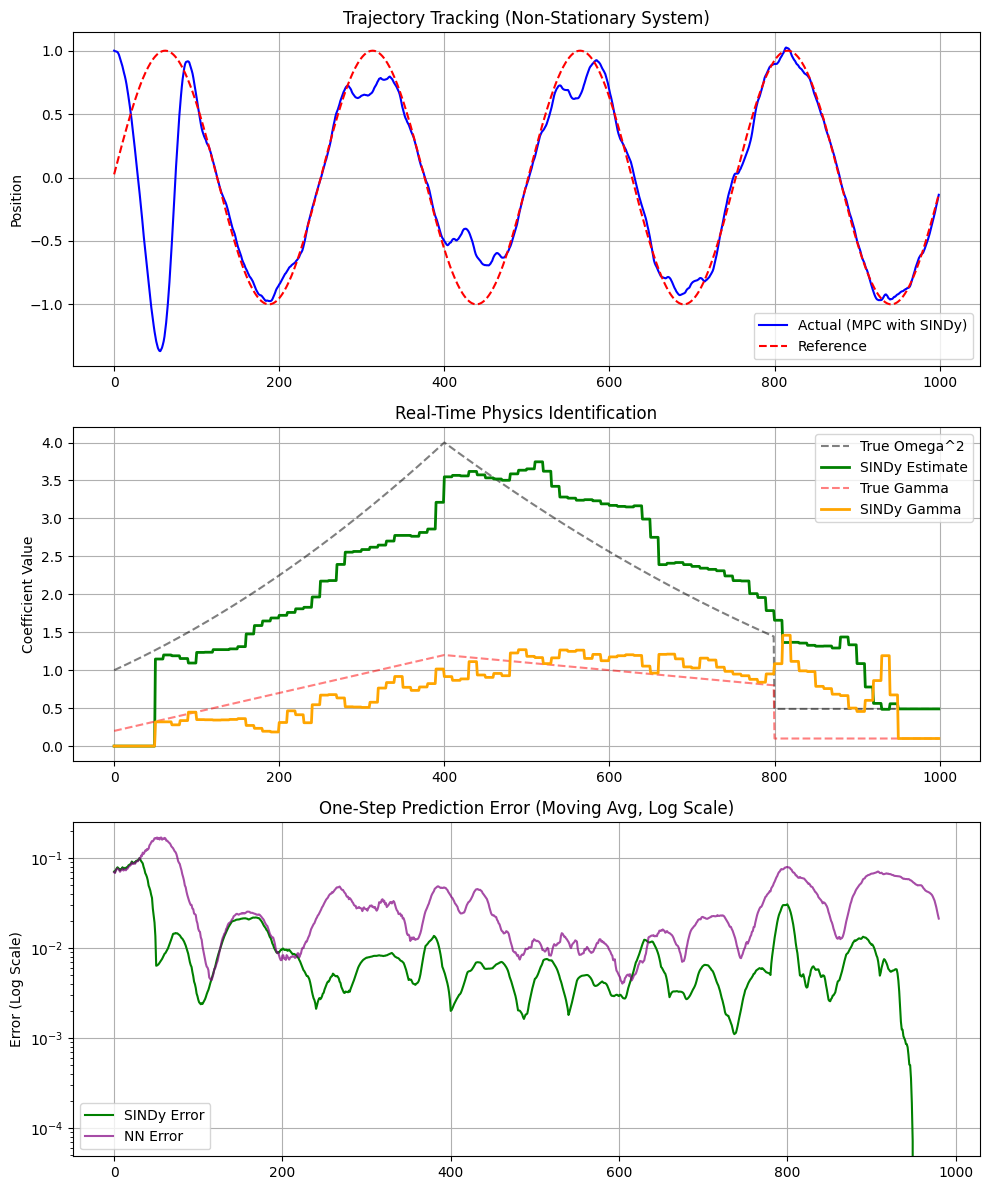


Starting Simulation 2: Neural Network + MPC (1000 steps)...
NN Step 0
NN Step 200
NN Step 400
NN Step 600
NN Step 800


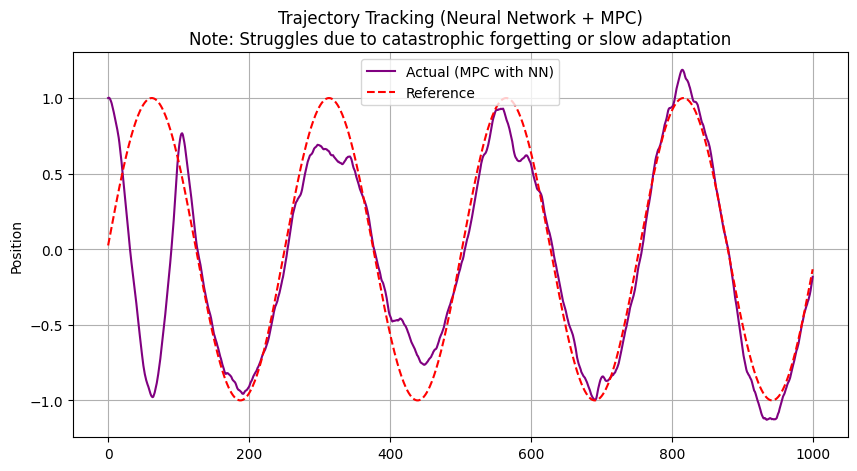


Starting Simulation 2: DQN (Model-Free) (1000 steps)...
DQN Step 0, Epsilon 1.00
DQN Step 200, Epsilon 0.50
DQN Step 400, Epsilon 0.18
DQN Step 600, Epsilon 0.07
DQN Step 800, Epsilon 0.05


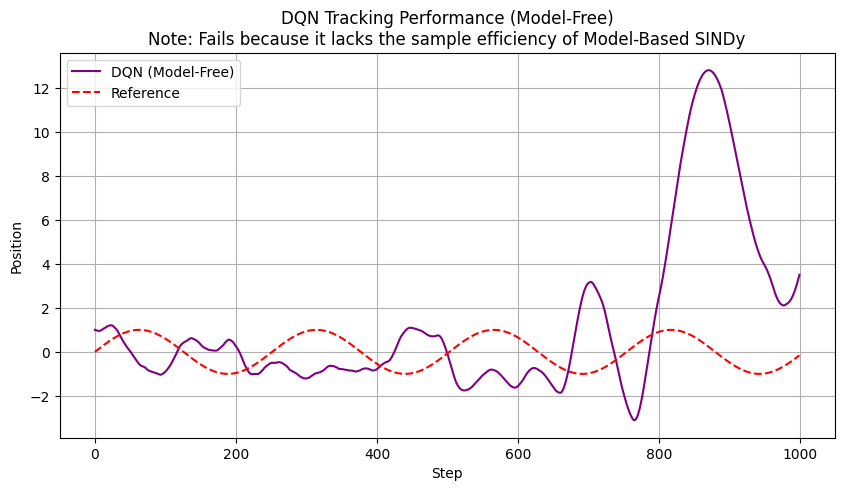

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================
# 0. Reference & Helpers
# ============================================================

def p_ref(t, dt):
    """Target trajectory: A sine wave we want to track."""
    time = t * dt
    return 1.0 * np.sin(0.5 * time)

def library(x, u):
    """
    Polynomial feature library.
    Features: [1, p, v, u, p^2, v^2, p*v, p*u, v*u, u^2]
    Indices:   0  1  2  3   4    5    6    7    8    9
    """
    p, v = x
    # Handle both 1D (single sample) and 2D (batch) inputs
    if np.ndim(p) == 0:
        return np.array([1, p, v, u, p**2, v**2, p*v, p*u, v*u, u**2])
    else:
        return np.stack([
            np.ones_like(p), p, v, u, p**2, v**2, p*v, p*u, v*u, u**2
        ], axis=1)

# ============================================================
# 1. Oscillator Environment (Non-stationary)
# ============================================================

class OscillatorEnv:
    def __init__(self, dt=0.05):
        self.dt = dt
        self.reset()

    def get_true_params(self, t_step):
        """Returns the True Omega and Gamma for a given timestep."""
        # Smooth drift logic
        if t_step < 400:
            # Phase 1: Drift up
            alpha = t_step / 400.0
            omega = 1.0 + 1 * alpha      # 1.0 -> 2
            gamma = 0.2 + 1 * alpha      # 0.2 -> 1.2
        elif t_step < 800:
            # Phase 2: Drift down
            alpha = (t_step - 400) / 400.0
            omega = 2 - 0.8 * alpha      # 2 -> 1.2
            gamma = 1.2 - 0.4 * alpha      # 1.2 -> 0.8
        else:
            # Phase 3: Steady
            omega = 0.7
            gamma = 0.1
        return omega, gamma

    def reset(self):
        self.t = 0
        self.x = np.array([1.0, 0.0])  # [position, velocity]
        return self.x.copy()

    def step(self, u):
        u = np.clip(u, -5, 5)
        p, v = self.x
        
        # Get physics parameters for current time
        omega, gamma = self.get_true_params(self.t)

        # Physics: dp = v, dv = -omega^2*p - gamma*v + u
        dp = v
        dv = -(omega**2) * p - gamma * v + u

        # Euler Integration
        self.x = self.x + self.dt * np.array([dp, dv])
        self.t += 1

        # Cost calculation
        pref = p_ref(self.t, self.dt)
        cost = (p - pref)**2 + 0.01 * u**2
        
        return self.x.copy(), -cost, omega, gamma

# ============================================================
# 2. SINDyC (With Sliding Window & Sparsity)
# ============================================================

class SINDyC:
    def __init__(self, window_size=300):
        self.window_size = window_size
        self.X = []
        self.Y = []
        # 10 features, 2 state variables (dp, dv)
        self.coeff = np.zeros((10, 2)) 
        
    def update(self, x, u, x_next, dt):
        # Compute derivative (finite difference)
        dx = (x_next - x) / dt
        
        self.X.append(library(x, u))
        self.Y.append(dx)

        # Sliding Window: Drop old data to adapt to new physics
        if len(self.X) > self.window_size:
            self.X.pop(0)
            self.Y.pop(0)

    def fit(self, threshold=0.05):
        if len(self.X) < 50: return

        X_mat = np.stack(self.X)
        Y_mat = np.stack(self.Y)

        # 1. Initial Least Squares
        Xi, _, _, _ = np.linalg.lstsq(X_mat, Y_mat, rcond=None)

        # 2. Thresholding (Make it Sparse)
        small_inds = np.abs(Xi) < threshold
        Xi[small_inds] = 0
        
        # 3. Refit on remaining terms
        for i in range(2):
            big_inds = ~small_inds[:, i]
            if np.sum(big_inds) > 0:
                Xi[big_inds, i], _, _, _ = np.linalg.lstsq(
                    X_mat[:, big_inds], Y_mat[:, i], rcond=None)
            else:
                Xi[:, i] = 0
                
        self.coeff = Xi

    def predict(self, x, u, dt):
        dx = library(x, u) @ self.coeff
        return x + dt * dx

# ============================================================
# 3. Neural Network (With Replay Buffer)
# ============================================================

class ReplayBuffer:
    def __init__(self, capacity=2000):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, x, u, dx_target):
        self.buffer.append((x, u, dx_target))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        x, u, dx = zip(*batch)
        return (torch.FloatTensor(np.array(x)), 
                torch.FloatTensor(np.array(u)).unsqueeze(1), 
                torch.FloatTensor(np.array(dx)))
    
    def __len__(self): return len(self.buffer)

class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: [p, v, u] (3 dims) -> Output: [dp, dv] (2 dims)
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, u):
        # Concatenate x and u
        xu = torch.cat([x, u], dim=1)
        return self.net(xu)

# ============================================================
# 4. MPC (Sequence Shooting)
# ============================================================

def mpc(model_predict, x0, horizon, dt, t0):
    best_u, best_cost = 0.0, float('inf')
    
    # Generate random sequences: (Num_Candidates, Horizon)
    num_candidates = 50
    u_seqs = np.random.uniform(-4, 4, size=(num_candidates, horizon))
    
    # Evaluate sequences
    for i in range(num_candidates):
        x = x0.copy()
        cost = 0.0
        
        for k in range(horizon):
            u = u_seqs[i, k]
            x = model_predict(x, u, dt)
            
            t_curr = t0 + k
            pref = p_ref(t_curr, dt)
            cost += (x[0] - pref)**2 + 0.01 * u**2
        
        if cost < best_cost:
            best_cost = cost
            best_u = u_seqs[i, 0] # Take first action of best sequence

    return best_u

# ============================================================
# 5. Main Simulation Loop (SINDy + MPC)
# ============================================================

env = OscillatorEnv()
sindy = SINDyC(window_size=150) # Smaller window = faster adaptation

# NN Setup
nn_model = NNModel()
optimizer = optim.Adam(nn_model.parameters(), lr=0.002)
buffer = ReplayBuffer()

# Metrics
history = {
    'p_true': [], 'p_ref': [], 
    'sindy_err': [], 'nn_err': [],
    'true_omega2': [], 'sindy_omega2': [],
    'true_gamma': [], 'sindy_gamma': []
}

x = env.reset()
TOTAL_STEPS = 1000

print(f"Starting Simulation 1: SINDy + MPC ({TOTAL_STEPS} steps)...")

for t in range(TOTAL_STEPS):
    
    # --- 1. Control (MPC) ---
    if t < 20:
        u = np.random.uniform(-2, 2) # Warmup
    else:
        u = mpc(sindy.predict, x, horizon=15, dt=env.dt, t0=env.t)

    # --- 2. Environment Step ---
    x_next, _, true_omega, true_gamma = env.step(u)
    
    # --- 3. SINDy Update ---
    sindy.update(x, u, x_next, env.dt)
    if t % 10 == 0: 
        sindy.fit(threshold=0.1)

    # --- 4. NN Update ---
    dx_target = (x_next - x) / env.dt
    buffer.push(x, u, dx_target)
    
    if len(buffer) > 64:
        bx, bu, bdx = buffer.sample(32)
        optimizer.zero_grad()
        pred_dx = nn_model(bx, bu)
        loss = nn.MSELoss()(pred_dx, bdx)
        loss.backward()
        optimizer.step()

    # --- 5. Logging ---
    pred_sindy = sindy.predict(x, u, env.dt)
    
    with torch.no_grad():
        tx = torch.FloatTensor(x).unsqueeze(0) # Shape (1, 2)
        tu = torch.FloatTensor([[u]])          # Shape (1, 1)
        pred_dx_nn = nn_model(tx, tu).numpy()[0]
        pred_nn = x + env.dt * pred_dx_nn
    
    history['p_true'].append(x_next[0])
    history['p_ref'].append(p_ref(env.t, env.dt))
    history['sindy_err'].append(np.linalg.norm(x_next - pred_sindy))
    history['nn_err'].append(np.linalg.norm(x_next - pred_nn))
    
    # Log Physics Parameters (True vs SINDy)
    history['true_omega2'].append(true_omega**2)
    history['true_gamma'].append(true_gamma)
    
    if np.sum(sindy.coeff) != 0:
        history['sindy_omega2'].append(-sindy.coeff[1, 1])
        history['sindy_gamma'].append(-sindy.coeff[2, 1])
    else:
        history['sindy_omega2'].append(0)
        history['sindy_gamma'].append(0)

    x = x_next

# ============================================================
# 6. Plotting Results (SINDy)
# ============================================================

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Tracking Performance
axs[0].plot(history['p_true'], label='Actual (MPC with SINDy)', color='blue')
axs[0].plot(history['p_ref'], label='Reference', linestyle='--', color='red')
axs[0].set_title("Trajectory Tracking (Non-Stationary System)")
axs[0].set_ylabel("Position")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Parameter Adaptation
axs[1].plot(history['true_omega2'], 'k--', label='True Omega^2', alpha=0.5)
axs[1].plot(history['sindy_omega2'], 'g', label='SINDy Estimate', linewidth=2)
axs[1].plot(history['true_gamma'], 'r--', label='True Gamma', alpha=0.5)
axs[1].plot(history['sindy_gamma'], 'orange', label='SINDy Gamma', linewidth=2)
axs[1].set_title("Real-Time Physics Identification")
axs[1].set_ylabel("Coefficient Value")
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Plot 3: Model Prediction Error
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma_sindy = moving_average(history['sindy_err'])
ma_nn = moving_average(history['nn_err'])

axs[2].plot(ma_sindy, label='SINDy Error', color='green')
axs[2].plot(ma_nn, label='NN Error', color='purple', alpha=0.7)
axs[2].set_title("One-Step Prediction Error (Moving Avg, Log Scale)")
axs[2].set_yscale('log')
axs[2].set_ylabel("Error (Log Scale)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# ============================================================
# 7. Simulation 2: Neural Network + MPC (Online Learning)
# ============================================================
# We now allow the NN to control the system to see if it can adapt.

print(f"\nStarting Simulation 2: Neural Network + MPC ({TOTAL_STEPS} steps)...")

env_nn = OscillatorEnv()
nn_control = NNModel()
opt_control = optim.Adam(nn_control.parameters(), lr=0.002)
buf_control = ReplayBuffer()

nn_history = {'p_true': [], 'p_ref': []}
x = env_nn.reset()

# Wrapper to make NN compatible with MPC function
def nn_predict_wrapper(x, u, dt):
    with torch.no_grad():
        tx = torch.FloatTensor(x).unsqueeze(0)
        tu = torch.FloatTensor([[u]])
        dx = nn_control(tx, tu).numpy()[0]
    return x + dt * dx

for t in range(TOTAL_STEPS):
    # Control
    if t < 50:
        u = np.random.uniform(-2, 2)
    else:
        u = mpc(nn_predict_wrapper, x, horizon=15, dt=env_nn.dt, t0=env_nn.t)
    
    # Step
    x_next, _, _, _ = env_nn.step(u)
    
    # Train
    dx_target = (x_next - x) / env_nn.dt
    buf_control.push(x, u, dx_target)
    
    if len(buf_control) > 64:
        bx, bu, bdx = buf_control.sample(32)
        opt_control.zero_grad()
        pred_dx = nn_control(bx, bu)
        loss = nn.MSELoss()(pred_dx, bdx)
        loss.backward()
        opt_control.step()
        
    # Log
    nn_history['p_true'].append(x_next[0])
    nn_history['p_ref'].append(p_ref(env_nn.t, env_nn.dt))
    x = x_next
    
    if t % 200 == 0: print(f"NN Step {t}")

# Plot NN
plt.figure(figsize=(10, 5))
#plt.plot(history['p_true'], label='Actual (MPC with SINDy)', color='blue')
plt.plot(nn_history['p_true'], label='Actual (MPC with NN)', color='purple')
plt.plot(nn_history['p_ref'], label='Reference', linestyle='--', color='red')
plt.title("Trajectory Tracking (Neural Network + MPC)\nNote: Struggles due to catastrophic forgetting or slow adaptation")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.show()


# ============================================================
# 8. Q-Learning Comparison (Model-Free RL)
# ============================================================
# We now run a DQN agent on the SAME environment to compare.
# We expect DQN to fail or perform poorly because Model-Free RL
# generally requires 100x more data to adapt than Model-Based.

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.net(x)

# Discrete actions for DQN (MPC used continuous)
dqn_actions = np.linspace(-4, 4, 11) 

def get_dqn_action(model, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(dqn_actions))
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state))
        return torch.argmax(q_values).item()

# DQN Setup
dqn_model = DQN(state_dim=3, action_dim=len(dqn_actions)) # state: p_error, v, p_ref
dqn_optimizer = optim.Adam(dqn_model.parameters(), lr=0.001)
dqn_buffer = collections.deque(maxlen=2000)

gamma = 0.95
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

# Reset Environment
x = env.reset()
dqn_history = {'p_true': [], 'p_ref': []}

print(f"\nStarting Simulation 2: DQN (Model-Free) ({TOTAL_STEPS} steps)...")

for t in range(TOTAL_STEPS):
    
    # 1. Construct State
    # Model-free needs context. We give it [Error, Velocity, Target]
    pref = p_ref(env.t, env.dt)
    state = np.array([x[0] - pref, x[1], pref])
    
    # 2. Action
    action_idx = get_dqn_action(dqn_model, state, epsilon)
    u = dqn_actions[action_idx]
    
    # 3. Step
    x_next, cost, _, _ = env.step(u)
    
    # 4. Next State
    pref_next = p_ref(env.t, env.dt)
    next_state = np.array([x_next[0] - pref_next, x_next[1], pref_next])
    
    # 5. Reward (Negative Cost)
    reward = -cost
    
    # 6. Train DQN
    dqn_buffer.append((state, action_idx, reward, next_state))
    
    if len(dqn_buffer) > 64:
        batch = random.sample(dqn_buffer, 32)
        b_s, b_a, b_r, b_ns = zip(*batch)
        
        b_s = torch.FloatTensor(np.array(b_s))
        b_a = torch.LongTensor(b_a).unsqueeze(1)
        b_r = torch.FloatTensor(b_r).unsqueeze(1)
        b_ns = torch.FloatTensor(np.array(b_ns))
        
        # Current Q
        curr_q = dqn_model(b_s).gather(1, b_a)
        
        # Target Q
        next_q = dqn_model(b_ns).max(1)[0].unsqueeze(1).detach()
        target_q = b_r + gamma * next_q
        
        loss = nn.MSELoss()(curr_q, target_q)
        dqn_optimizer.zero_grad()
        loss.backward()
        dqn_optimizer.step()
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    # Logging
    dqn_history['p_true'].append(x_next[0])
    dqn_history['p_ref'].append(pref)
    x = x_next
    
    if t % 200 == 0: print(f"DQN Step {t}, Epsilon {epsilon:.2f}")

# Plot DQN Results
plt.figure(figsize=(10, 5))
plt.plot(dqn_history['p_true'], label='DQN (Model-Free)', color='purple')
plt.plot(dqn_history['p_ref'], 'r--', label='Reference')
plt.title("DQN Tracking Performance (Model-Free)\nNote: Fails because it lacks the sample efficiency of Model-Based SINDy")
plt.ylabel("Position")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

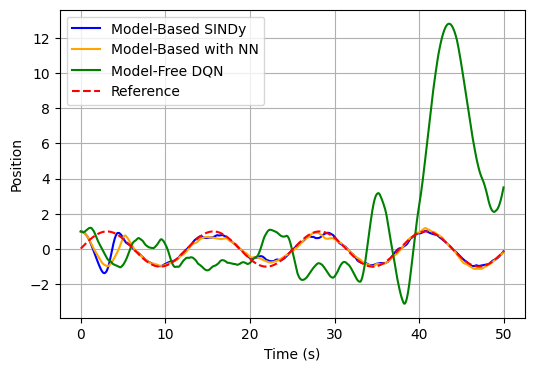

In [24]:
# ============================================================
# 9. Comparison Plot (Time-based X-Axis)
# ============================================================
plt.figure(figsize=(6, 4))

# Create Time Axis (Seconds)
dt = 0.05
time_axis = np.arange(len(history['p_true'])) * dt

plt.plot(time_axis, history['p_true'], label='Model-Based SINDy', color='blue')
plt.plot(time_axis, nn_history['p_true'], label='Model-Based with NN', color='orange')
plt.plot(time_axis, dqn_history['p_true'], label='Model-Free DQN', color='green')
plt.plot(time_axis, nn_history['p_ref'], label='Reference', linestyle='--', color='red')

#plt.title("Control Performance Comparison: SINDy vs NN vs DQN")
plt.ylabel("Position")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

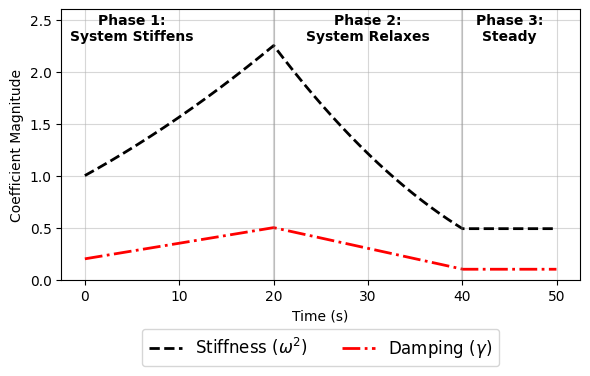

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Parameter Evolution Logic (Copied from OscillatorEnv)
# ============================================================
def get_true_params(t_step):
    """Returns the True Omega and Gamma for a given timestep."""
    if t_step < 400:
        # Phase 1: Drift up (System gets stiffer and thicker)
        alpha = t_step / 400.0
        omega = 1.0 + 0.5 * alpha      # 1.0 -> 1.5
        gamma = 0.2 + 0.3 * alpha      # 0.2 -> 0.5
    elif t_step < 800:
        # Phase 2: Drift down (System gets looser and thinner)
        alpha = (t_step - 400) / 400.0
        omega = 1.5 - 0.8 * alpha      # 1.5 -> 0.7
        gamma = 0.5 - 0.4 * alpha      # 0.5 -> 0.1
    else:
        # Phase 3: Steady State
        omega = 0.7
        gamma = 0.1
    return omega, gamma

# ============================================================
# Generate Data
# ============================================================
TOTAL_STEPS = 1000
dt = 0.05
time_axis = np.arange(TOTAL_STEPS) * dt

omega_sq_values = [] # Stiffness term in equation
gamma_values = []    # Damping term in equation

for t in range(TOTAL_STEPS):
    w, g = get_true_params(t)
    omega_sq_values.append(w**2)
    gamma_values.append(g)

# ============================================================
# Plot
# ============================================================
plt.figure(figsize=(6, 4))

# Plot Stiffness (omega^2)
plt.plot(time_axis, omega_sq_values, color='black', linewidth=2, linestyle='--', label=r'Stiffness ($\omega^2$)')

# Plot Damping (gamma)
plt.plot(time_axis, gamma_values, color='red', linewidth=2, linestyle='-.', label=r'Damping ($\gamma$)')

# Annotate Phases
plt.axvline(x=400*dt, color='gray', alpha=0.3)
plt.axvline(x=800*dt, color='gray', alpha=0.3)

# Add text labels for context
plt.text(5, 2.3, "Phase 1:\nSystem Stiffens", fontsize=10, ha='center', fontweight='bold')
plt.text(30, 2.3, "Phase 2:\nSystem Relaxes", fontsize=10, ha='center', fontweight='bold')
plt.text(45, 2.3, "Phase 3:\nSteady", fontsize=10, ha='center', fontweight='bold')

plt.xlabel("Time (s)")
plt.ylabel("Coefficient Magnitude")
plt.legend(fontsize=12)
plt.legend(
    fontsize=12,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.35),
    ncol=2
)
plt.grid(True, alpha=0.5)

# Set limits to make room for text
plt.ylim(0, 2.6)

plt.tight_layout()
plt.show()